# Библиотеки

In [1]:
import numpy
import math
import pandas
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn
import sklearn
import sklearn.svm
import sklearn.model_selection
import sklearn.preprocessing
import scipy
from scipy.optimize import curve_fit
import statsmodels.stats.descriptivestats

In [2]:
# From https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
class SeabornFig2Grid():
    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, seaborn.axisgrid.FacetGrid) or \
            isinstance(self.sg, seaborn.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, seaborn.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(numpy.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

# Загрузка выборки

In [3]:
trainRaw = pandas.read_csv("task2/train.csv")
trainRaw.sample(5)

index        y    x1  x2  x3  x4  x5      x6   x7      x8      x9  x10  \
3408    3408   698.14  15.0   1  32   0   1  649.75  0.0  349.86  311.73  0.0   
9423    9423   349.58  18.0   1  21   0   1  148.87  0.0   11.49  126.04  0.0   
5608    5608   865.01  18.0   1  20   0   1    0.00  0.0   17.85  802.65  0.0   
15000  15000   278.65  18.0   1  29   0   1  157.04  0.0   37.81  137.79  0.0   
8966    8966  1129.25  11.0   1  27   0   1    0.00  0.0   60.31  491.17  0.0   

        x11     x12  x13  x14  x15   x16  x17     x18  
3408   2.71  464.92  0.0  0.0  0.0  0.01  0.0  664.31  
9423   0.00   82.94  0.0  0.0  0.0  0.00  0.0  137.54  
5608   0.00  470.04  0.0  0.0  0.0  5.03  0.0  825.52  
15000  0.00  106.33  0.0  0.0  0.0  0.00  0.0  175.59  
8966   0.00   75.00  0.0  0.0  0.0  0.00  0.0  551.49

In [4]:
testRaw = pandas.read_csv("task2/test.csv")
testRaw.sample(5)

index    x1  x2  x3  x4  x5      x6   x7      x8      x9   x10     x11  \
548    548  11.0   1  26   1   1  746.47  0.0   93.19  500.83  0.00  170.16   
599    599  11.0   0  43   0   1  581.78  0.0  101.66  547.02  0.00    0.00   
605    605  17.0   1  45   0   1    0.00  0.0   32.25  188.00  0.00    0.37   
745    745  15.0   1  31   0   1  429.60  0.0   74.26  315.11  0.00   13.77   
114    114  11.0   0  26   0   1    0.00  0.0   35.35  219.25  0.04    0.28   

        x12  x13  x14   x15   x16   x17     x18  
548  440.22  0.0  0.0  1.63  0.00  1.96  769.73  
599  648.69  0.0  0.0  0.00  0.00  0.00  648.69  
605   30.37  0.0  0.0  0.00  0.00  0.00  220.62  
745  165.22  0.0  0.0  0.00  0.55  0.00  403.68  
114   46.82  0.0  0.0  0.00  0.00  0.00  254.92

# Анализ и предобработка выборки

In [5]:
print(len(trainRaw))
print(len(testRaw))

16000
1000


In [6]:
trainRaw.describe()

index            y            x1            x2            x3  \
count  16000.000000  16000.00000  16000.000000  16000.000000  16000.000000   
mean    7999.500000    471.28077     15.169750      0.750750     32.961188   
std     4618.946489    393.65383      4.184603      0.432592      8.948425   
min        0.000000      6.25000     10.000000      0.000000     19.000000   
25%     3999.750000    208.43500     11.000000      1.000000     26.000000   
50%     7999.500000    362.87500     15.000000      1.000000     32.000000   
75%    11999.250000    593.59750     18.000000      1.000000     38.000000   
max    15999.000000   2714.44000     23.000000      1.000000     60.000000   

                 x4            x5            x6       x7            x8  \
count  16000.000000  16000.000000  16000.000000  16000.0  16000.000000   
mean       0.196500      1.179938    191.381912      0.0     52.460246   
std        0.397363      0.571582    399.199579      0.0     81.209825   
min        0.000000      1.000000      0.000000      0.0      0.000000   
25%        0.000000      1.000000      0.000000      0.0      9.130000   
50%        0.000000      1.000000     59.290000      0.0     26.895000   
75%        0.000000      1.000000    262.212500      0.0     63.190000   
max        1.000000     17.000000  17023.760000      0.0   1455.440000   

                 x9           x10           x11           x12      x13  \
count  16000.000000  16000.000000  16000.000000  16000.000000  16000.0   
mean     278.174804      0.069534      7.280819    166.824287      0.0   
std      253.285298      0.410552     33.254749    216.672893      0.0   
min        0.000000      0.000000      0.000000      0.000000      0.0   
25%      105.020000      0.000000      0.000000     33.900000      0.0   
50%      209.825000      0.000000      0.050000     95.350000      0.0   
75%      371.340000      0.000000      2.290000    217.472500      0.0   
max     2502.370000     11.400000    977.570000   2615.740000      0.0   

           x14           x15           x16           x17           x18  
count  16000.0  16000.000000  16000.000000  16000.000000  16000.000000  
mean       0.0      0.454579      1.107541      0.577436    340.702423  
std        0.0      2.885566      8.401314      7.188730    306.372223  
min        0.0      0.000000      0.000000      0.000000      3.900000  
25%        0.0      0.000000      0.000000      0.000000    134.395000  
50%        0.0      0.000000      0.000000      0.000000    256.280000  
75%        0.0      0.000000      0.000000      0.000000    446.172500  
max        0.0    112.230000    448.880000    599.950000   2939.220000

In [7]:
testRaw.describe()

index           x1           x2          x3           x4  \
count  1000.000000  1000.000000  1000.000000  1000.00000  1000.000000   
mean    499.500000    14.962000     0.780000    33.14600     0.195000   
std     288.819436     4.159791     0.414454     9.13357     0.396399   
min       0.000000    10.000000     0.000000    19.00000     0.000000   
25%     249.750000    11.000000     1.000000    26.00000     0.000000   
50%     499.500000    14.000000     1.000000    32.00000     0.000000   
75%     749.250000    18.000000     1.000000    38.00000     0.000000   
max     999.000000    23.000000     1.000000    60.00000     1.000000   

                x5           x6      x7           x8           x9  \
count  1000.000000  1000.000000  1000.0  1000.000000  1000.000000   
mean      1.186000   218.391270     0.0    67.021990   328.096190   
std       0.541939   347.678177     0.0    81.689549   266.107688   
min       1.000000     0.000000     0.0     0.930000    29.860000   
25%       1.000000     0.000000     0.0    20.355000   146.107500   
50%       1.000000    63.980000     0.0    43.460000   262.395000   
75%       1.000000   337.142500     0.0    79.337500   424.205000   
max       6.000000  3945.630000     0.0   939.830000  2134.630000   

               x10          x11          x12     x13     x14          x15  \
count  1000.000000  1000.000000  1000.000000  1000.0  1000.0  1000.000000   
mean      0.074100    11.517680   196.002140     0.0     0.0     0.539210   
std       0.404951    51.522965   223.987454     0.0     0.0     2.439515   
min       0.000000     0.000000     0.000000     0.0     0.0     0.000000   
25%       0.000000     0.000000    46.777500     0.0     0.0     0.000000   
50%       0.000000     0.570000   116.690000     0.0     0.0     0.000000   
75%       0.000000     3.842500   270.030000     0.0     0.0     0.000000   
max       4.660000   877.580000  1569.880000     0.0     0.0    38.510000   

               x16          x17          x18  
count  1000.000000  1000.000000  1000.000000  
mean      1.362030     0.450220   409.511720  
std      13.003923     3.694759   321.010581  
min       0.000000     0.000000    52.930000  
25%       0.000000     0.000000   187.080000  
50%       0.000000     0.000000   326.680000  
75%       0.000000     0.000000   526.235000  
max     380.980000    87.780000  2263.040000

In [8]:
#res = statsmodels.stats.descriptivestats.Description(trainRaw,
    # stats=["nobs", "missing", "mean", "std_err", "ci", "ci", "std", "iqr", "mad", "coef_var", "range", "max", "min", "skew", "kurtosis", "mode",
    #        "median", "percentiles", "distinct", "top", "freq"],
    #use_t=True)
#display(res.summary())

### Наблюдение. Признаки x7, x13, x14 почему-то всегда 0 :). Удалим их

In [9]:
# Проверим, все ли признаки 0? Если True, то все
print(sum(trainRaw["x7"] == 0.0) == len(trainRaw))
print(sum(trainRaw["x13"] == 0.0) == len(trainRaw))
print(sum(trainRaw["x14"] == 0.0) == len(trainRaw))

print(sum(testRaw["x7"] == 0.0) == len(testRaw))
print(sum(testRaw["x13"] == 0.0) == len(testRaw))
print(sum(testRaw["x14"] == 0.0) == len(testRaw))

True
True
True
True
True
True


In [10]:
x_columns = set(trainRaw.columns)
print(x_columns)
x_columns.remove("x7")
x_columns.remove("x13")
x_columns.remove("x14")

x_columns.remove("y")
x_columns.remove("index")

x_columns = list(x_columns)
x_columns = sorted(x_columns, key=lambda x: int(x[1:]))
print(x_columns)

XRaw = trainRaw[x_columns]
YRaw = trainRaw["y"]
train1 = trainRaw[x_columns + ["index", "y"]]
test1  = testRaw[x_columns + ["index"]]
X1 = train1[x_columns]
Y1 = train1["y"]

{'x7', 'x2', 'x11', 'x18', 'index', 'x4', 'x6', 'x3', 'x16', 'x8', 'x9', 'x1', 'x10', 'x13', 'x12', 'x5', 'x17', 'x15', 'y', 'x14'}
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x15', 'x16', 'x17', 'x18']


Text(0.5, 1.0, 'График плотности вероятности ответов')

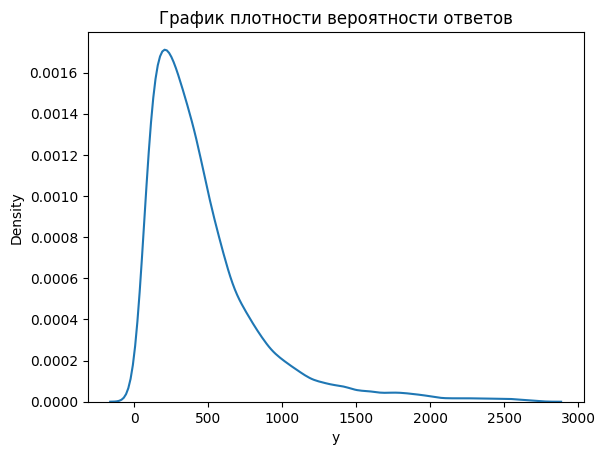

In [11]:
seaborn.kdeplot(data=train1, x="y")
plt.title("График плотности вероятности ответов")

In [50]:
print(len(x_columns))

15


### Построим разные графики для визуализации данных

#### График А

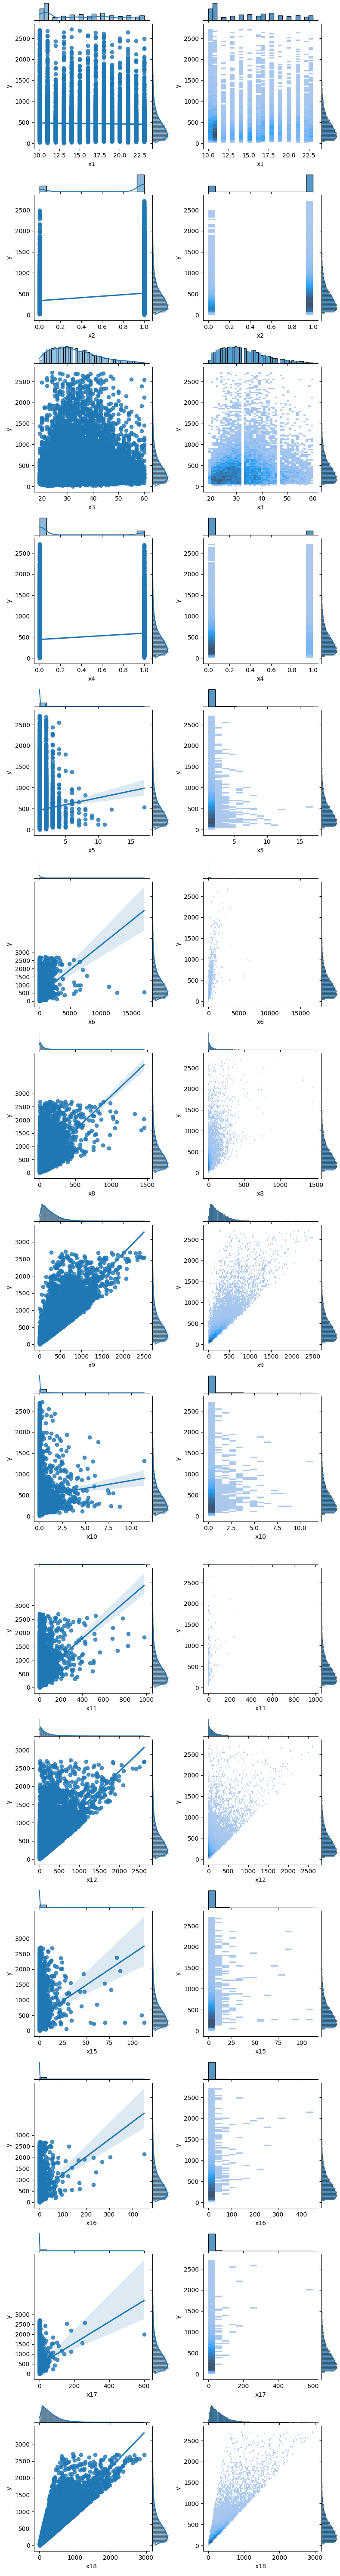

In [61]:
fig = plt.figure(figsize=(8, 15*4))
gs = gridspec.GridSpec(15, 2)

for i in range(len(x_columns)):
    col = x_columns[i]
    right = seaborn.jointplot(
        x=train1[col], y=train1["y"],
        kind='hist')
    left  = seaborn.jointplot(
        x=train1[col], y=train1["y"],
        kind='reg')#, ci=90)

    SeabornFig2Grid(left, fig, gs[2*i])
    SeabornFig2Grid(right, fig, gs[2*i + 1])

gs.tight_layout(fig)
plt.show()

#### График Б

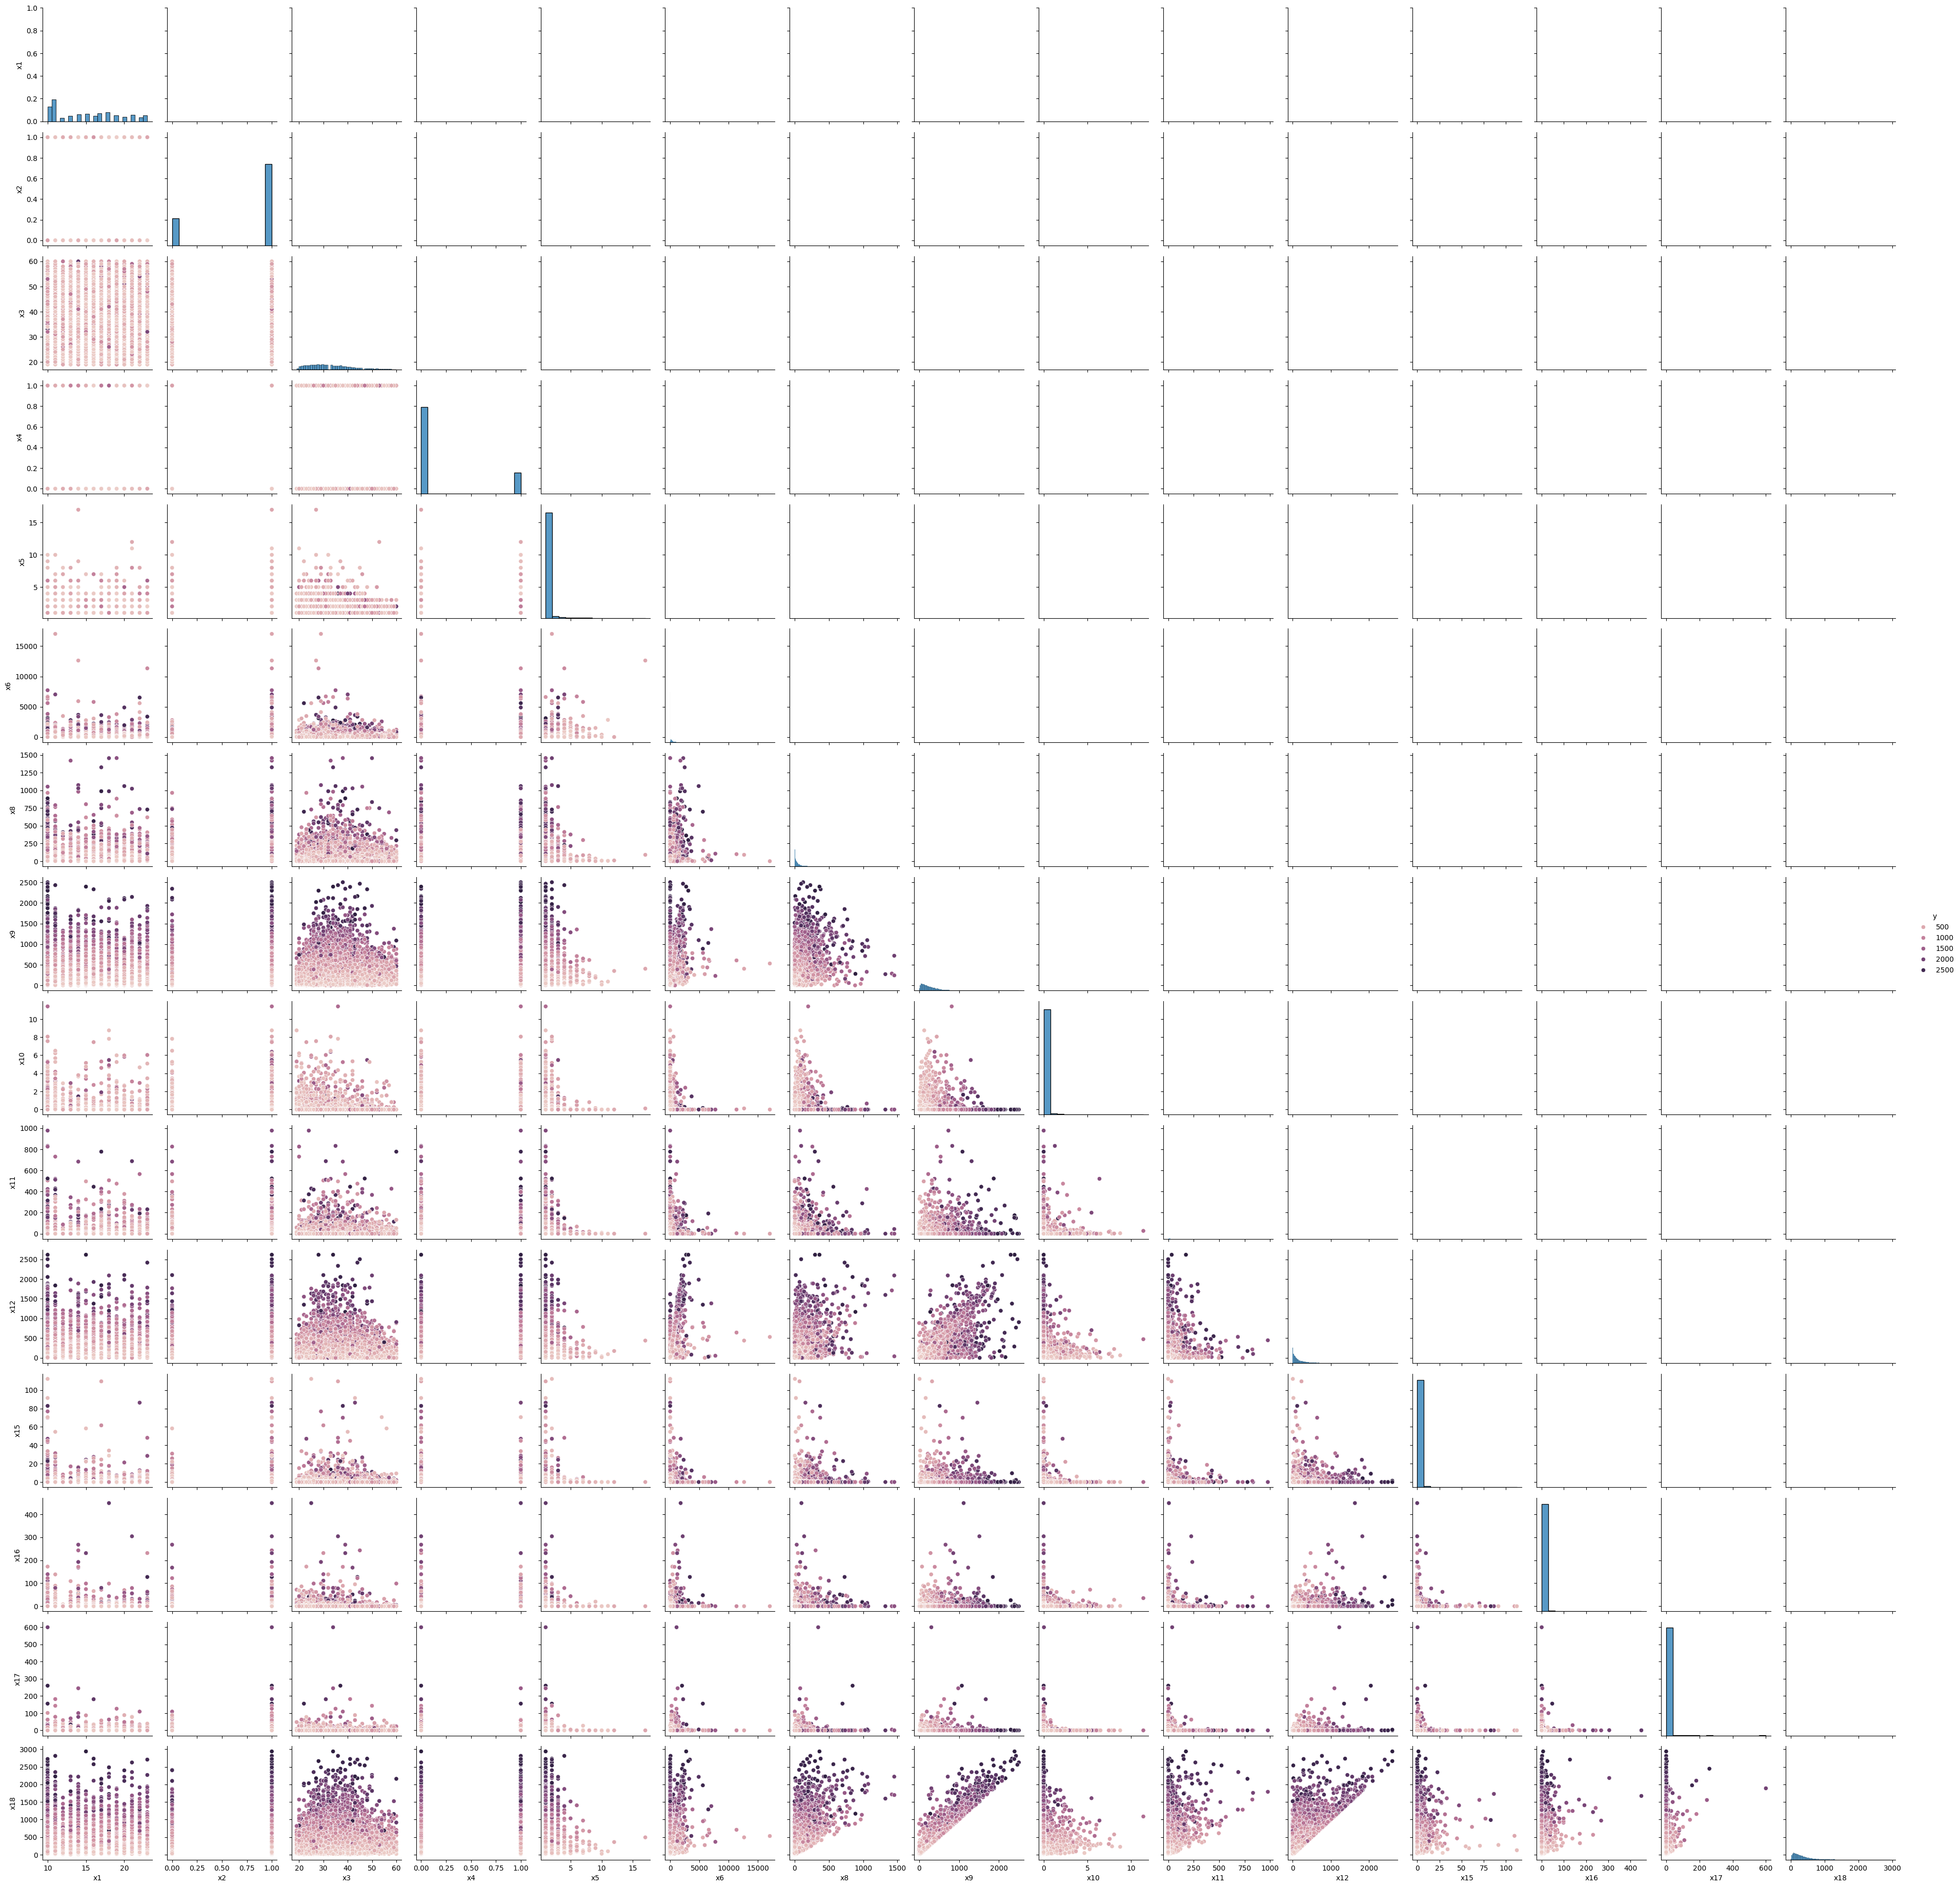

In [62]:
g = seaborn.PairGrid(train1[x_columns + ["y"]], hue="y", vars=x_columns)
g.figure.dpi = 100
g.map_diag(seaborn.histplot, hue=None)
g.map_lower(seaborn.scatterplot)
g.add_legend()

### Анализ графиков

х2, х4 принимают только 2 значения: 0 и 1. По этим значениям нужно предсказать $y \in [0, 2750]$. Что не возможно, так как значению фиксированному значения x будет соответствовать множество значений y. Но по графику А видно, что у распределений y при фиксированном x есть какое-то распределение, построим его на отдельном графике.

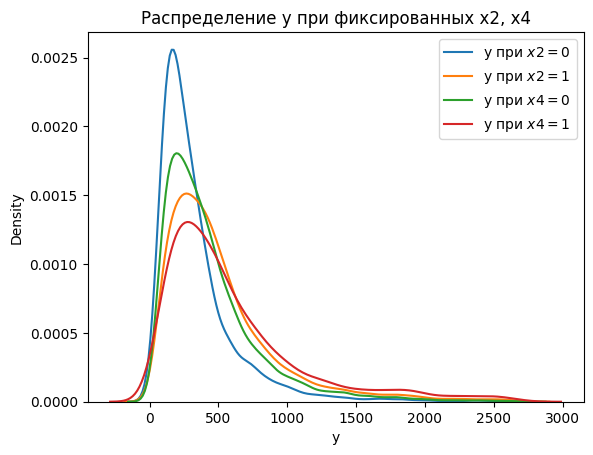

In [68]:
x2 = train1["x2"]
x4 = train1["x4"]

plt.title("Распределение y при фиксированных x2, x4")

seaborn.kdeplot(data=train1["y"][x2 == 0], label="y при $x2=0$")
seaborn.kdeplot(data=train1["y"][x2 == 1], label="y при $x2=1$")
seaborn.kdeplot(data=train1["y"][x4 == 0], label="y при $x4=0$")
seaborn.kdeplot(data=train1["y"][x4 == 1], label="y при $x4=1$")
plt.legend()

Да, средние значения немного разные, но как-то выглядит не информативно. Исключим их из выборки.

x5 и x1 тоже достаточно дискретны, но их оставим.

In [218]:
x_columns2 = x_columns.copy()
x_columns2.remove("x2")
x_columns2.remove("x4")
print(x_columns2)

train2 = train1[x_columns2 + ["index", "y"]]

test2  = test1[x_columns2 + ["index"]]

X2 = train2[x_columns2].to_numpy()
Y2 = train2["y"].to_numpy()

Xp2 = test2[x_columns2].to_numpy()
Ip2 = test2["index"].to_numpy()

['x1', 'x3', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x15', 'x16', 'x17', 'x18']


## Предобработка данных

Выполним нормировку данных. Будем использовать два способа: \
1. Мин-макс масштабирование, чтобы привести значения в диапазон от 0 до 1, повышая устойчивость численных алгоритмов. Применим для у, так как его нужно предсказывать и не хочется, чтобы поменялись его статистические свойства. Хотим, чтобы поменялся лишь диапазон. x1, x3 распределены примерно равномерно. Конечно, у них есть смещение ближе к 0, но для них тоже применяем это масштабирование.

2. Надёжное масштабирование (robust), которое хорошо применяется при наличии выбросов. Очевидно, что выброс есть у x5, x6 - самые правые точки, при этом y этих точек примерно равен наиболее вероятному, что не даёт дополнительной информации об объекте. Аналогично x8, x10, x11, x15, x16, x17. А вот у x9, x12, x18 наблюдается хорошая зависимость: для максимальных значений x, значения y максимальны, поэтому для этих признаков применим 1-ое масштабирование. 

In [13]:
def Scale(df, isTrain):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    robust_scaler = sklearn.preprocessing.RobustScaler()

    # Apply Min-Max Scaling to selected columns
    columns_min_max = ['x1', 'x3', 'x9', 'x12', 'x18']
    #if (isTrain):
    #    columns_min_max += ['y']
    df_min_max = pandas.DataFrame(min_max_scaler.fit_transform(df[columns_min_max]), columns=columns_min_max)

    # Apply Robust Scaling to other columns
    columns_robust = ['x5', 'x6', 'x8', 'x10', 'x11', 'x15', 'x16', 'x17']
    df_robust = pandas.DataFrame(robust_scaler.fit_transform(df[columns_robust]), columns=columns_robust)

    # Combine the scaled data
    df_combined = pandas.concat([df_min_max, df_robust, df.drop(columns=columns_min_max + columns_robust)], axis=1)

    return df_combined

In [14]:
train3 = Scale(train2, True)
test3 = Scale(test2, False)
X3 = train3[x_columns2].to_numpy()
Y3 = train3["y"].to_numpy()
Xp3 = test3[x_columns2].to_numpy()
Ip3 = test3["index"].to_numpy()

In [15]:
train3.describe()

x1            x3            x9           x12           x18  \
count  16000.000000  16000.000000  16000.000000  16000.000000  16000.000000   
mean       0.397673      0.340517      0.111165      0.063777      0.114741   
std        0.321893      0.218254      0.101218      0.082834      0.104374   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.076923      0.170732      0.041968      0.012960      0.044457   
50%        0.384615      0.317073      0.083851      0.036452      0.085980   
75%        0.615385      0.463415      0.148395      0.083140      0.150673   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 x5            x6            x8           x10           x11  \
count  16000.000000  1.600000e+04  16000.000000  16000.000000  16000.000000   
mean       0.179938  5.037590e-01      0.472905      0.069534      3.157563   
std        0.571582  1.522428e+00      1.502217      0.410552     14.521725   
min        0.000000 -2.261143e-01     -0.497503      0.000000     -0.021834   
25%        0.000000 -2.261143e-01     -0.328616      0.000000     -0.021834   
50%        0.000000 -1.355253e-17      0.000000      0.000000      0.000000   
75%        0.000000  7.738857e-01      0.671384      0.000000      0.978166   
max       16.000000  6.469741e+01     26.425176     11.400000    426.864629   

                x15           x16           x17         index            y  
count  16000.000000  16000.000000  16000.000000  16000.000000  16000.00000  
mean       0.454579      1.107541      0.577436   7999.500000    471.28077  
std        2.885566      8.401314      7.188730   4618.946489    393.65383  
min        0.000000      0.000000      0.000000      0.000000      6.25000  
25%        0.000000      0.000000      0.000000   3999.750000    208.43500  
50%        0.000000      0.000000      0.000000   7999.500000    362.87500  
75%        0.000000      0.000000      0.000000  11999.250000    593.59750  
max      112.230000    448.880000    599.950000  15999.000000   2714.44000

In [16]:
test3.describe()

x1           x3           x9          x12          x18  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.381692     0.345024     0.141695     0.124852     0.161341   
std       0.319984     0.222770     0.126431     0.142678     0.145246   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.076923     0.170732     0.055231     0.029797     0.060698   
50%       0.307692     0.317073     0.110480     0.074331     0.123863   
75%       0.615385     0.463415     0.187358     0.172007     0.214154   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                x5           x6            x8          x10          x11  \
count  1000.000000  1000.000000  1.000000e+03  1000.000000  1000.000000   
mean      0.186000     0.458000  3.994743e-01     0.074100     2.849103   
std       0.541939     1.031250  1.384979e+00     0.404951    13.408709   
min       0.000000    -0.189771 -7.210613e-01     0.000000    -0.148341   
25%       0.000000    -0.189771 -3.917264e-01     0.000000    -0.148341   
50%       0.000000     0.000000  6.028164e-17     0.000000     0.000000   
75%       0.000000     0.810229  6.082736e-01     0.000000     0.851659   
max       5.000000    11.513381  1.519722e+01     4.660000   228.239427   

               x15          x16          x17        index  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean      0.539210     1.362030     0.450220   499.500000  
std       2.439515    13.003923     3.694759   288.819436  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000   249.750000  
50%       0.000000     0.000000     0.000000   499.500000  
75%       0.000000     0.000000     0.000000   749.250000  
max      38.510000   380.980000    87.780000   999.000000

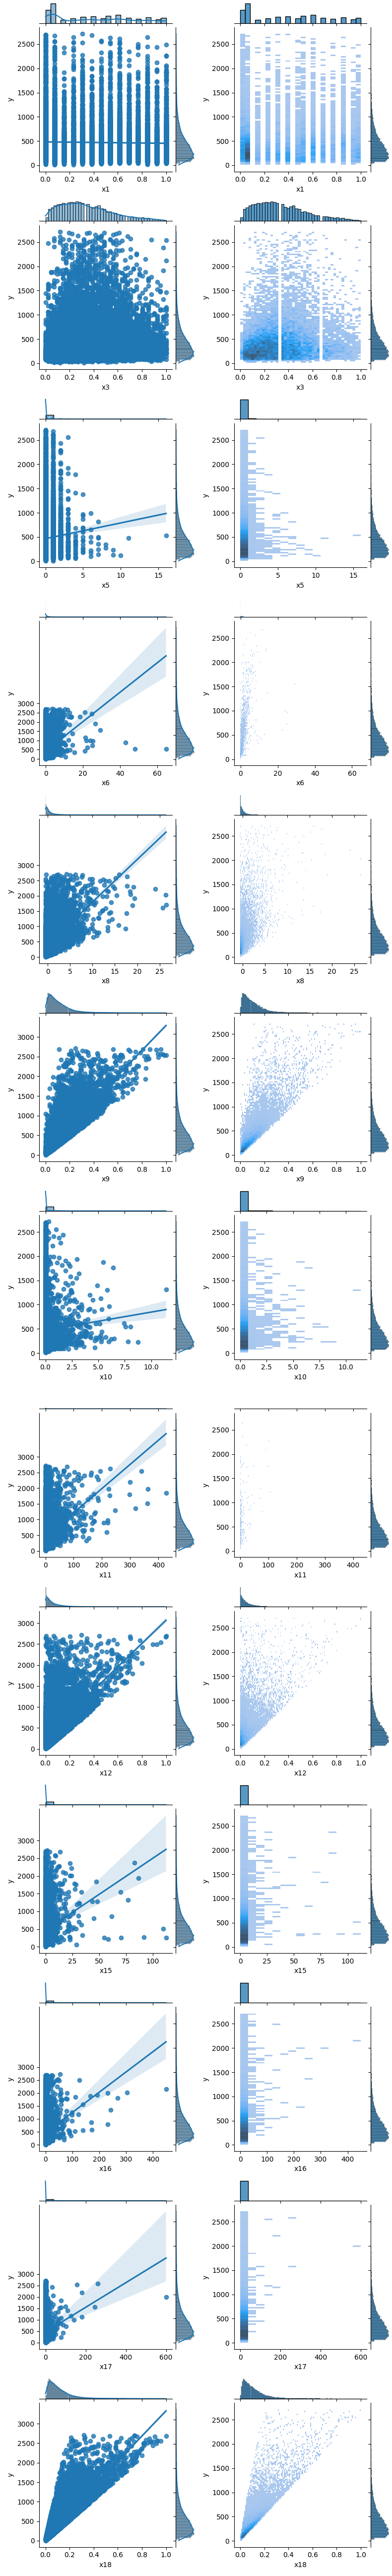

In [17]:
n = 13
fig = plt.figure(figsize=(8, n*4))
gs = gridspec.GridSpec(n, 2)

for i in range(len(x_columns2)):
    col = x_columns2[i]
    right = seaborn.jointplot(
        x=train3[col], y=train3["y"],
        kind='hist')
    left  = seaborn.jointplot(
        x=train3[col], y=train3["y"],
        kind='reg')

    SeabornFig2Grid(left, fig, gs[2*i])
    SeabornFig2Grid(right, fig, gs[2*i + 1])
    if (i == n - 1):
        break

gs.tight_layout(fig)
plt.show()

## Линейная регрессия

In [60]:
def GetRandomSeed():
    return int((time.time() * 10**8) % 4294967295)

def MAPE(y_answ, y_pred):
    return 1 / len(y_answ) * numpy.sum( numpy.abs((y_answ - y_pred) / y_answ) )

In [19]:
class ModelBase(object):
    """
    Базовый класс модели.
    """

    def __init__(self, **params):
        self.print_progress = params.get("print_progress", False)
        self.quality_metric = params.get("quality_metric", MAPE)
    
    def Train(self, X, Y):
        # X - матрица l на n объектов-признаков:
        # l = число объектов = число строк.
        # n = число признаков = число столбцов.
        
        # Y - вектор ответов.
        raise NotImplementedError()

    def Predict(self, new_x):
        raise NotImplementedError()

    def TestOnDataset(self, X_test, Y_test):
        assert(len(X_test) == len(Y_test))
        # Проверить, насколько модель точно предсказывает ответы на выборке.
        # Возвращает долю удачно предсказанных ответов (от 0 до 1).
        y_pred = []
        for idx in range(0, len(X_test)):
            pred = self.Predict(X_test[idx])
            y_pred.append(pred)
        return self.quality_metric(Y_test, numpy.array(y_pred))
    
    def PredictAll(self, X):
        y_pred = []
        for x in X:
            y_pred.append(self.Predict(x))
        return numpy.array(y_pred)

In [126]:
class TrainOptimizeAndTestModel(object):
    """
    Класс для облегчения обучения, оптимизации параметров поиском по сетке, и тестирования моделей.
    """

    def __init__(self, modelType, X, Y, defaultModelParams = {}, test_size = 0.2):
        self.test_size = test_size
        self.modelType = modelType
        self.defaultModelParams = defaultModelParams

        self.X_train, self.X_test, self.Y_train, self.Y_test = sklearn.model_selection.train_test_split(
            X, Y, test_size = self.test_size,
            random_state = GetRandomSeed(), # С каждым запуском случайное разбиение датасета.
        )

    def TestReport(self, model):
        score = model.TestOnDataset(self.X_test, self.Y_test)
        Report(self.Y_train, self.Y_test, score)

    def SimpleTrainTest(self):
        self.model = self.modelType(**self.defaultModelParams)
        self.model.Train(self.X_train, self.Y_train)
        return self.model.TestOnDataset(self.X_test, self.Y_test)

    def SimpleTrainTestReport(self):
        print(f"Score: {self.SimpleTrainTest():.4f}.")

    def TrainKFoldTest(self, foldsCount = 10, params = None):
        # Выборка разбивается на тестовую и обучающую.
        # Обучающая выборка в свою очередь разбивается на k частей (fold).
        # Обучение происходит на k-1 части (новая обучающая выборка), а на оставшейся (валидационная выборка) проверяется качество модели.
        # В качестве итоговой модели выбирается та модель, которая показала наибольшее качество на отложенной части.
        # Полученная итоговая модель тестируется на ранее отложенной тестовой выборке, на которой определяется итоговое качество модели.
        # Все разбиения выполняются так, чтобы процентное соотношение классов (ответов) было одинаковым в разбиении и исходном датасете (stratified разбиение).

        # Почитать подробнее: https://education.yandex.ru/handbook/ml/article/kross-validaciya

        if (params is None):
            params = self.defaultModelParams

        skfold = sklearn.model_selection.KFold(n_splits = foldsCount, shuffle = True, random_state = GetRandomSeed())

        models = []
        accuracies = []

        i = 1

        for train_index, validate_index in skfold.split(self.X_train, self.Y_train):
            X_train, Y_train = self.X_train[train_index], self.Y_train[train_index]
            X_validate, Y_validate = self.X_train[validate_index], self.Y_train[validate_index]

            model = self.modelType(**params)
            model.Train(X_train, Y_train)
            accuracy = model.TestOnDataset(X_validate, Y_validate)

            print(f"Fold = {i}, accuracy = {accuracy * 100:.2f}")

            models.append(model)
            accuracies.append(accuracy)
            i += 1
        
        return {"models" : models, "scores" : accuracies}

    def TrainKFoldTestOpt(self, foldsCount = 10, params = None):
        # Тоже, что и TrainKFoldTest, но возвращает только наилучшую модель и её точность.
        if (params is None):
            params = self.defaultModelParams

        skfold = sklearn.model_selection.KFold(n_splits = foldsCount, shuffle = True, random_state = GetRandomSeed())

        best_accuracy = 0
        best_model = None

        i = 1

        for train_index, validate_index in skfold.split(self.X_train, self.Y_train):
            X_train, Y_train = self.X_train[train_index], self.Y_train[train_index]
            X_validate, Y_validate = self.X_train[validate_index], self.Y_train[validate_index]

            model = self.modelType(**params)
            model.Train(X_train, Y_train)
            accuracy = model.TestOnDataset(X_validate, Y_validate)

            print(f"Fold = {i}, accuracy = {accuracy * 100}")

            if (accuracy > best_accuracy):
                best_model = model
                best_accuracy = accuracy
            i += 1
        
        return (best_model, best_accuracy)

    def _calcGrid(params_dict):
        # Преобразовать рекурсивно сетку параметров: {"a" : [1, 2, 3], "b" : [10, 11]}
        # В массив словарей: [{"a" : 1, "b" : 10}, {"a" : 1, "b" : 11}, {"a" : 2, "b" : 10} и т.д.]

        if (len(params_dict.keys()) == 1):
            key = next(iter(params_dict.keys()))
            params_grid = []
            for value in params_dict[key]:
                params_grid.append({key : value})
            return params_grid
        else:
            # Запоминаем текущие ключ-значение.
            key = next(iter(params_dict.keys()))
            values = params_dict[key]
            del params_dict[key]
            # Уменьшили размер словаря на 1. Рекурсивный вызов.
            params_grid_intermediate = TrainOptimizeAndTestModel._calcGrid(params_dict)
            # Добавляем запомненные значения к результату.
            params_grid_final = []
            for v in values:
                for d in params_grid_intermediate:
                    # Копируем словарь.
                    d_copy = d.copy()
                    # Добавляем к нему новый параметр.
                    d_copy[key] = v
                    # В params_grid_final добавляем изменённый словарь
                    params_grid_final.append(d_copy)
            return params_grid_final

    def GridSearchByGrid(self, params_grid, foldsCount = 10):
        res = []
        print("Progress: ", end='')

        for params in params_grid:
            print("#", end='')
            trainedModels = self.TrainKFoldTest(foldsCount = foldsCount, params = params)
            res.append({"params" : params, "kFoldModels" : trainedModels})
        
        print("")
        return res

In [74]:
class M1(ModelBase):
    def __init__(self, **params):
        super(M1, self).__init__(**params)

    def EmpiricalRisk(coefs, X, Y):
        Y_pred = numpy.dot(X, coefs[1:]) + coefs[0]
        return MAPE(Y, Y_pred)
    
    def Train(self, X, Y):
        # X - матрица l на n объектов-признаков:
        # l = число объектов = число строк.
        # n = число признаков = число столбцов.
        
        # Y - вектор ответов.
        res = scipy.optimize.minimize(M1.EmpiricalRisk, numpy.zeros(len(X[0]) + 1), args=(X, Y))
        #rint(res)
        self.coefs = res.x

    def Predict(self, new_x):
        return numpy.dot(new_x, self.coefs[1:]) + self.coefs[0]

In [75]:
helper = TrainOptimizeAndTestModel(M1, X2, Y2)
helper.SimpleTrainTestReport()

Score: 0.2411.


In [66]:
helper = TrainOptimizeAndTestModel(M1, X3, Y3)
helper.SimpleTrainTestReport()

Score: 0.2425.


In [114]:
class M1r(ModelBase):
    def __init__(self, **params):
        super(M1r, self).__init__(**params)
        self.mu = params.get("mu", 1)
        self.tau = params.get("tau", 1)

    def EmpiricalRisk(coefs, mu, tau, X, Y):
        Y_pred = numpy.dot(X, coefs[1:]) + coefs[0] + mu * numpy.sum(numpy.abs(coefs)) + tau * numpy.dot(coefs, coefs)
        return MAPE(Y, Y_pred)
    
    def Train(self, X, Y):
        # X - матрица l на n объектов-признаков:
        # l = число объектов = число строк.
        # n = число признаков = число столбцов.
        
        # Y - вектор ответов.
        res = scipy.optimize.minimize(M1r.EmpiricalRisk, numpy.zeros(len(X[0]) + 1), args=(self.mu, self.tau, X, Y))
        #rint(res)
        self.coefs = res.x

    def Predict(self, new_x):
        return numpy.dot(new_x, self.coefs[1:]) + self.coefs[0]

In [169]:
helper = TrainOptimizeAndTestModel(M1r, X2, Y2, defaultModelParams={"mu": 5e-3, "tau" : 1e-7})
helper.SimpleTrainTestReport()

Score: 0.2413.


In [149]:
def GetRandomSeed():
    return int((time.time() * 10**8) % 4294967295)


In [163]:
helper = TrainOptimizeAndTestModel(M1r, X3, Y3, defaultModelParams={"mu": 0, "tau" : 0})

def Funct(coefs):
    helper.defaultModelParams["mu"] = coefs[0]
    helper.defaultModelParams["tau"] = coefs[1]
    return helper.SimpleTrainTest()

def Print(intermediate_result: scipy.optimize.OptimizeResult):
    print(intermediate_result)

res = scipy.optimize.minimize(Funct, [1e-4, 1e-7], method="BFGS", tol=1e-4, options={"maxiter" : 10}, callback=Print)
print(res)

 fun: 0.24383357136812314
   x: [ 1.000e-04  1.000e-07]
 fun: 0.24380176681152654
   x: [ 1.000e-04  1.000e-07]


KeyboardInterrupt: 

In [184]:
class Ensemble(ModelBase):
    def __init__(self, **params):
        super(Ensemble, self).__init__(**params)
        self.baseModel = params["baseModel"]
        self.baseModelParams = params["baseModelParams"]
        self.foldsCount = params.get("foldsCount", 10)

    def Train(self, X, Y):
        # X - матрица l на n объектов-признаков:
        # l = число объектов = число строк.
        # n = число признаков = число столбцов.
        
        # Y - вектор ответов.
        helper = TrainOptimizeAndTestModel(self.baseModel, X, Y, defaultModelParams=self.baseModelParams)
        res = helper.TrainKFoldTest(foldsCount = self.foldsCount, params = self.baseModelParams)

        self.ensemble = []
        for idx in range(len(res["models"])):
            if (res["scores"][idx] < 25):
                self.ensemble.append(res["models"][idx])

    def Predict(self, new_x):
        y = 0
        for m in self.ensemble:
            y += m.Predict(new_x)
        y /= len(self.ensemble)
        return y

In [171]:
helper = TrainOptimizeAndTestModel(Ensemble, X2, Y2, defaultModelParams={"baseModel" : M1, "baseModelParams" : {}})
helper.SimpleTrainTestReport()

Fold = 1, accuracy = 24.52
Fold = 2, accuracy = 24.03
Fold = 3, accuracy = 24.33
Fold = 4, accuracy = 24.76
Fold = 5, accuracy = 25.37
Fold = 6, accuracy = 24.45
Fold = 7, accuracy = 24.62
Fold = 8, accuracy = 25.08
Fold = 9, accuracy = 23.85
Fold = 10, accuracy = 24.22
Score: 0.2351.


In [204]:
helper = TrainOptimizeAndTestModel(Ensemble, X2, Y2, defaultModelParams={"baseModel" : M1r, "foldsCount" : 20, "baseModelParams" : {"mu": 1e-4, "tau" : 5e-8}})
helper.SimpleTrainTestReport()

Fold = 1, accuracy = 25.20
Fold = 2, accuracy = 24.23
Fold = 3, accuracy = 24.88
Fold = 4, accuracy = 25.21
Fold = 5, accuracy = 24.43
Fold = 6, accuracy = 24.26
Fold = 7, accuracy = 24.17
Fold = 8, accuracy = 26.13
Fold = 9, accuracy = 26.33
Fold = 10, accuracy = 24.61
Fold = 11, accuracy = 24.51
Fold = 12, accuracy = 24.72
Fold = 13, accuracy = 23.61
Fold = 14, accuracy = 24.65
Fold = 15, accuracy = 25.23
Fold = 16, accuracy = 23.77
Fold = 17, accuracy = 23.80
Fold = 18, accuracy = 25.32
Fold = 19, accuracy = 25.52
Fold = 20, accuracy = 23.87
Score: 0.2420.


In [200]:
helper = TrainOptimizeAndTestModel(Ensemble, X3, Y3, defaultModelParams={"baseModel" : M1r, "foldsCount" : 10, "baseModelParams" : {"mu": 5e-5, "tau" : 5e-7}})
helper.SimpleTrainTestReport()

Fold = 1, accuracy = 24.62
Fold = 2, accuracy = 24.71
Fold = 3, accuracy = 24.39
Fold = 4, accuracy = 25.08
Fold = 5, accuracy = 24.68
Fold = 6, accuracy = 23.60
Fold = 7, accuracy = 24.73
Fold = 8, accuracy = 43.11
Fold = 9, accuracy = 24.00
Fold = 10, accuracy = 24.19
Score: 0.2484.


In [216]:
helper = TrainOptimizeAndTestModel(M1r, X2, Y2, defaultModelParams={"mu": 5e-3, "tau" : 1e-7})
helper.SimpleTrainTestReport()

Score: 0.2389.


In [220]:
Yp2 = helper.model.Predict(Xp2)
df = pandas.DataFrame({"index": Ip2, "y": Yp2})
df.to_csv("task2/try2.csv", index = False)

In [65]:
sum_accuracy = 0
itersCount = 5

for i in range(itersCount):
    helper = TrainOptimizeAndTestModel(SVR, X3, Y3)

    print(f"Попытка {i + 1}.")

    res = helper.TrainKFoldTestOpt(params = {})

    print("Точность на валидационной (при использовании kFold) выборке:", res[1])
    accuracy = helper.Test(res[0])
    print("Точность на тестовой (не используемой при kFold) выборке:", accuracy)
    sum_accuracy += accuracy

print("\nСредняя точность:", sum_accuracy / itersCount)

Попытка 1.
Fold = 1, accuracy = 101396.43112791736


KeyboardInterrupt: 

# Test

In [20]:

def mape_loss(params, X, y):
    intercept = params[0]
    coefficients = params[1:]
    y_pred = X.dot(coefficients) + intercept
    return numpy.mean(numpy.abs((y - y_pred) / y))


Сырая выборка

In [30]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(XRaw, YRaw, test_size=0.2, random_state=777)

lin_model = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

y_pred = lin_model.predict(X_test)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(mape)

initial_params = numpy.zeros(X_train.shape[1] + 1)
result = scipy.optimize.minimize(mape_loss, initial_params, args=(X_train, y_train))
optimal_params = result.x

0.35120383401094785


In [31]:
mape_model = sklearn.linear_model.LinearRegression()
mape_model.coef_ = optimal_params[1:]
mape_model.intercept_ = optimal_params[0]

y_pred = mape_model.predict(X_test.values)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.2428179176822586


X1 - Убрали полностью нулевые признаки.

In [27]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X1, Y1, test_size=0.2, random_state=777)

lin_model = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

y_pred = lin_model.predict(X_test)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(mape)

initial_params = numpy.zeros(X_train.shape[1] + 1)
optimal_params = result.x
result = scipy.optimize.minimize(mape_loss, initial_params, args=(X_train, y_train))

0.35120383401094785


In [29]:
mape_model = sklearn.linear_model.LinearRegression()
mape_model.coef_ = optimal_params[1:]
mape_model.intercept_ = optimal_params[0]

y_pred = mape_model.predict(X_test.values)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.2428179176822586


X2 - убрали х2, х4. Столбцы у которых либо 0, либо 1 значения.

In [50]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X2, Y2, test_size=0.2, random_state=777)

lin_model = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

y_pred = lin_model.predict(X_test)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(mape)

initial_params = numpy.zeros(X_train.shape[1] + 1)
result = scipy.optimize.minimize(mape_loss, initial_params, args=(X_train, y_train))
optimal_params = result.x

0.36180701237650204


In [51]:
mape_model = sklearn.linear_model.LinearRegression()
mape_model.coef_ = optimal_params[1:]
mape_model.intercept_ = optimal_params[0]

y_pred = mape_model.predict(X_test)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.2464473670335832


X3 - выполнили нормировку

In [58]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X3, Y3, test_size=0.2, random_state=777)

lin_model = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

y_pred = lin_model.predict(X_test)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(mape)

initial_params = numpy.zeros(X_train.shape[1] + 1)
result = scipy.optimize.minimize(mape_loss, initial_params, args=(X_train, y_train))
optimal_params = result.x

0.36180701237672763


In [59]:
mape_model = sklearn.linear_model.LinearRegression()
mape_model.coef_ = optimal_params[1:]
mape_model.intercept_ = optimal_params[0]

y_pred = mape_model.predict(X_test)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.249122498201925
